In [1]:
#!pip install sklearn
#!pip install bcml4pheno
#!pip install tensorflow 

In [2]:
import os
import csv
import math 
import numpy as np
import pandas as pd
import ROOT
from bcml4pheno import bcml_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.26/06


2022-09-09 09:37:22.285999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 09:37:22.286030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(os.getcwd())

/home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis


In [4]:
def read_csv(folder, name):
    dict_={}
    ax=next(os.walk(folder))[2]
    ax.sort(reverse = True )
    for file in ax:
        if "Cutflow" in file: continue
        elif name in file:
            try:
                df=pd.read_csv(
                    os.path.join(folder,file)
                )
                dict_.update(
                    {file.removesuffix(f"_{name}") : df}
                )
            except:
                pass
    return dict_

def load_all_csv(folder):
    data_dict={}
    results_names=[
        #hadronic selection
        "b_tau_tau_hadronic_zero_jets",
        "b_tau_tau_hadronic_(al)one_jet",
        "b_b_tau_tau_hadronic",
        #semileptonic selection
        "b_tau_tau_semileptonic_zero_jets",
        "b_tau_tau_semileptonic_(al)one_jet",
        "b_b_tau_tau_semileptonic",
        #leptonic selection
        "b_tau_tau_leptonic_zero_jets",
        "b_tau_tau_leptonic_(al)one_jet",
        "b_b_tau_tau_leptonic"
    ]
    for name in results_names:
        data_dict.update({name: read_csv(folder,f"{name}.csv")})
    return data_dict


In [5]:
def prepare_features(data_dict,name='',channel="",features=[]):
    signal_feature=[]
    for i in range(data_dict[channel][name].shape[0]):
        row=[]
        for feature in features:
            row+=[data_dict[channel][name][feature][i]]        
        signal_feature.append(row)
    return np.array(signal_feature)

def concat_signals(data_dict,signal_list,channel,features):
    names=signal_list.copy()
    name_0=names.pop(0)
    arr=prepare_features(data_dict,name_0,channel,features)[:,:]
    for name in names:
        arr=np.concatenate((arr,prepare_features(data_dict,name,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

def concat_channels(data_dict,signal_list,channels,features):
    chs=channels.copy()
    ch_0=chs.pop(0)
    arr=concat_signals(data_dict,signal_list,ch_0,features)
    for channel in chs:
        arr=np.concatenate((arr,concat_signals(data_dict,signal_list,channel,features)[:,:]))
    np.random.shuffle(arr)
    return arr

In [6]:
def prepare_to_train (signal,bkg):
    bkg_vsize=min([len(signal),len(bkg)])
    signal_vsize=bkg_vsize

    pred=signal[:signal_vsize, :]
    pred=np.concatenate((pred,bkg[:bkg_vsize, :]))
    
    labels=np.zeros(np.shape(pred)[0])
    labels[:signal_vsize] = 1
    
    return pred , labels
def get_yield(csv_files_path,signal_list,channel):
    df=pd.read_csv(
            os.path.join(
                csv_files_path,
                f"Cutflow_{channel}.csv"
            )
        )
    yields=0
    for name in signal_list:
        yields+=df[name][(df.shape[0]-1)]
    return yields
def get_yields(csv_files_path,names,channels):
    dict_={}
    for channel in channels:
        dict_[channel]={}
        for name in names: 
            dict_[channel][name]=get_yield(csv_files_path,[name],channel)
    return dict_

In [7]:
from ROOT import *

def Draw_Discrtiminator(data_dict,name,channels,csv_files_path,images_folder,model,features):
    c1 = TCanvas( f'c-{name}', '', 0, 0, 1280, 720)
    c1.SetGrid()
    c1.SetLogy()
    hs = THStack(name,name)
    colors = [kBlue,kRed,3, 7, 6, kBlack, 2,  9, 1, 43, 97, 38, 3, 7, 6, kBlack, 2, 4, 8]
    hist_dict={}
    for i, channel in enumerate(channels):
        h = TH1F(f"{name}_{channel}",f"{name}_{channel};score;nevents(137/fb)", 100, 0.0,1.0)
        h.SetLineWidth(1)
        h.SetLineColor(kBlack)
        h.SetFillColor(colors[i])
        for score in model.predict_proba(concat_signals(data_dict,[name],channel,features)):
            h.Fill(score)
        h.Scale(get_yield(csv_files_path,[name],channel)/h.Integral())
        hist_dict[channel]=h
        hs.Add(h)
    
    hs.Draw("HIST")
    c1.SaveAs(os.path.join(os.getcwd(),images_folder,f"{name}.png"))
    return (name,hist_dict)

In [8]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "03_delphes_analysis"
)
csv_files_path=os.path.join(folder_out,"csv_files")
print(csv_files_path)

data=load_all_csv(csv_files_path)

print(list(data.keys()))

/home/crisfer2694/Pheno_BSM/Leptoquarks_searches/03_delphes_analysis/csv_files
['b_tau_tau_hadronic_zero_jets', 'b_tau_tau_hadronic_(al)one_jet', 'b_b_tau_tau_hadronic', 'b_tau_tau_semileptonic_zero_jets', 'b_tau_tau_semileptonic_(al)one_jet', 'b_b_tau_tau_semileptonic', 'b_tau_tau_leptonic_zero_jets', 'b_tau_tau_leptonic_(al)one_jet', 'b_b_tau_tau_leptonic']


In [9]:
channels=[
    "b_tau_tau_hadronic_(al)one_jet",
    #"b_tau_tau_hadronic_zero_jets",
    #"b_b_tau_tau_hadronic"
]

In [10]:
a=list(data['b_tau_tau_hadronic_zero_jets']["ww"])
a.sort(reverse = True)
a

['pT_{b_{1}}(GeV)',
 'pT_{#tau_{2}}(GeV)',
 'pT_{#tau_{1}}(GeV)',
 'light_jets_multiplicity',
 'Q_#tau_{1}Q_#tau_{2}',
 'Mass_{b_{1}}(GeV)',
 'Mass_{#tau_{2}}(GeV)',
 'Mass_{#tau_{1}}(GeV)',
 'MET(GeV)',
 'Energy_{b_{1}}(GeV)',
 'Energy_{#tau_{2}}(GeV)',
 'Energy_{#tau_{1}}(GeV)',
 '#phi_{b_{1}}',
 '#phi_{MET}',
 '#phi_{#tau_{2}}',
 '#phi_{#tau_{1}}',
 '#eta_{b_{1}}',
 '#eta_{#tau_{2}}',
 '#eta_{#tau_{1}}',
 '#Delta{pT}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{pT}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{R}_{b_{1}#tau_{2}}',
 '#Delta{R}_{b_{1}#tau_{1}}',
 '#Delta{R}_{#tau_{1}#tau_{2}}',
 '#Delta{#vec{p}}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{p}}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{pT}}_{b_{1}#tau_{2}}(GeV)',
 '#Delta{#vec{pT}}_{b_{1}#tau_{1}}(GeV)',
 '#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV)',
 '#Delta{#phi}_{b_{1}#tau_{2}}',
 '#Delta{#phi}_{b_{1}#tau_{1}}',
 '#Delta{#phi}_{#tau_{1}#tau_{2}}',
 '#Delta{#eta}_{b_{1}#tau_{2

In [11]:
features=[
    'MET(GeV)',
    '#phi_{MET}',
    
    'Mass_{j_{1}}(GeV)',
    'pT_{j_{1}}(GeV)',
    '#phi_{j_{1}}',
    '#eta_{j_{1}}',
    
    'Mass_{b_{1}}(GeV)',
    'pT_{b_{1}}(GeV)',
    '#phi_{b_{1}}',
    '#eta_{b_{1}}',
    
    'Mass_{#tau_{1}}(GeV)',
    'pT_{#tau_{1}}(GeV)',
    '#phi_{#tau_{1}}',
    '#eta_{#tau_{1}}',
    
    'Mass_{#tau_{2}}(GeV)',
    'pT_{#tau_{2}}(GeV)',
    '#phi_{#tau_{2}}',
    '#eta_{#tau_{2}}'
]

In [12]:
mass=1500
name=f"Tau_LQ_{mass}"
signal_names=[
    name
]
bkg_names=[
    "ttbar",
    "stop",
    "z_jets",
    "w_jets",
    "ww",
    "wz",
    "zz"
]

signal= concat_channels(data,signal_names,channels,features)
bkg= concat_channels(data,bkg_names,channels,features)

In [13]:
sig_yield=get_yields(csv_files_path,signal_names,channels)
bkg_yield=get_yields(csv_files_path,bkg_names,channels)
print(sig_yield)
print(bkg_yield)

{'b_tau_tau_hadronic_(al)one_jet': {'Tau_LQ_1500': 43.098339540000005}}
{'b_tau_tau_hadronic_(al)one_jet': {'ttbar': 95238.6044621255, 'stop': 16381.225598863635, 'z_jets': 57339.58389397528, 'w_jets': 59437.12842342218, 'ww': 330.9798668416, 'wz': 342.0559341807106, 'zz': 356.0718596256}}


In [14]:
pred1 , labels1= prepare_to_train(signal,bkg)
trainPred, testPred, trainLab, testLab = train_test_split(pred1, labels1, test_size=0.25)

logreg_model = bcml_model(
    make_pipeline(
        StandardScaler(), 
        LogisticRegression()
    )
)

logreg_model.fit(trainPred, trainLab)

In [15]:
tpr=logreg_model.tpr(testLab, preds=testPred)
tpr

0.9790446146913024

In [16]:
fpr=logreg_model.fpr(testLab, preds=testPred)
fpr

0.01460013074743953

In [17]:
signal_names=[name,f"LQ_LQ_{mass}"]
images_folder="No jet conditions"
os.system(f"rm -rf '{images_folder}'")
os.system(f"mkdir -p '{images_folder}'")
def mapping(name):
    return Draw_Discrtiminator(data,name,channels,csv_files_path,images_folder,logreg_model,features)
histograms=dict(map(mapping,signal_names+bkg_names))


Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/Tau_LQ_1500.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/LQ_LQ_1500.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/ttbar.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/stop.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/z_jets.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/w_jets.png has been created
Info in <TCanvas::Print>: png file /home/crisfer2694/Pheno_BSM/Leptoquarks_searches/04_ML_analysis/No jet conditions/ww.png 

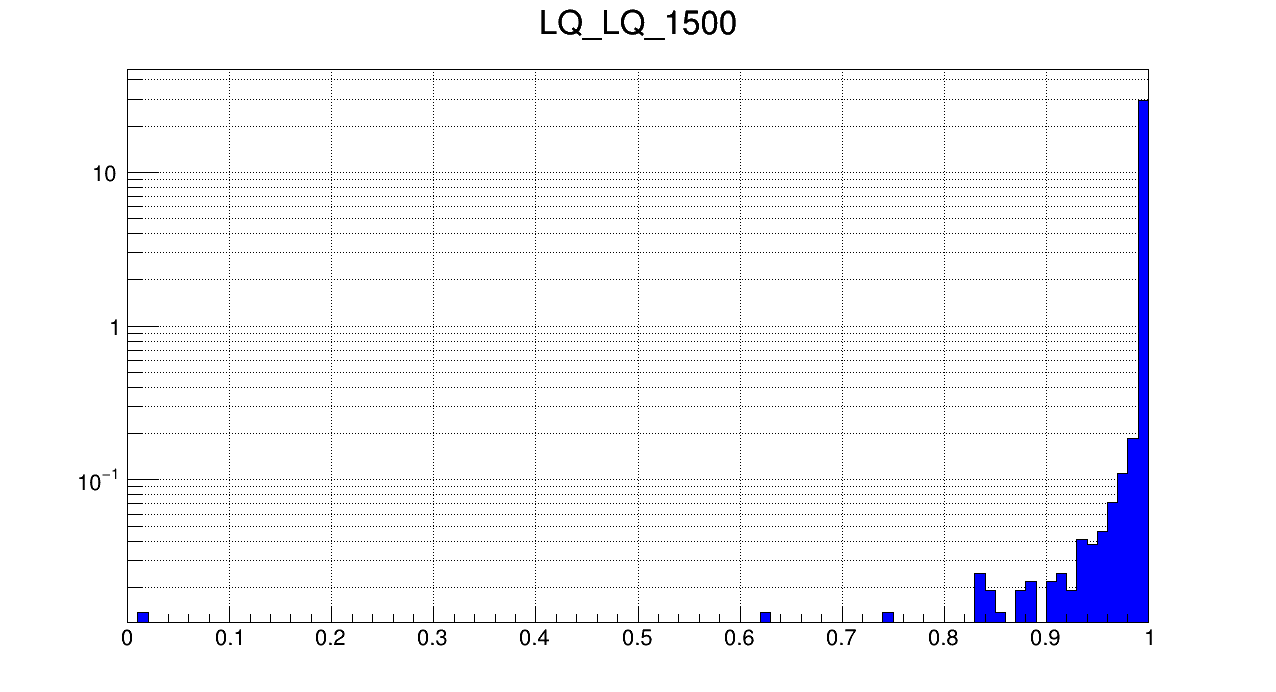

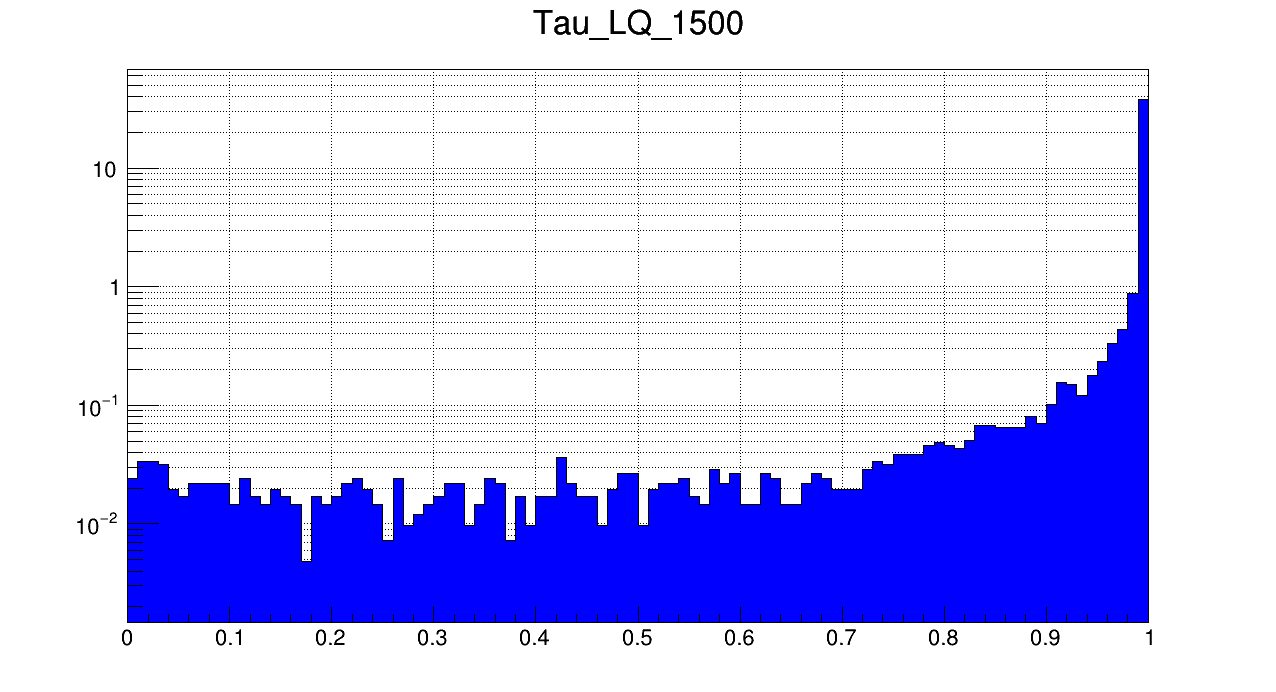

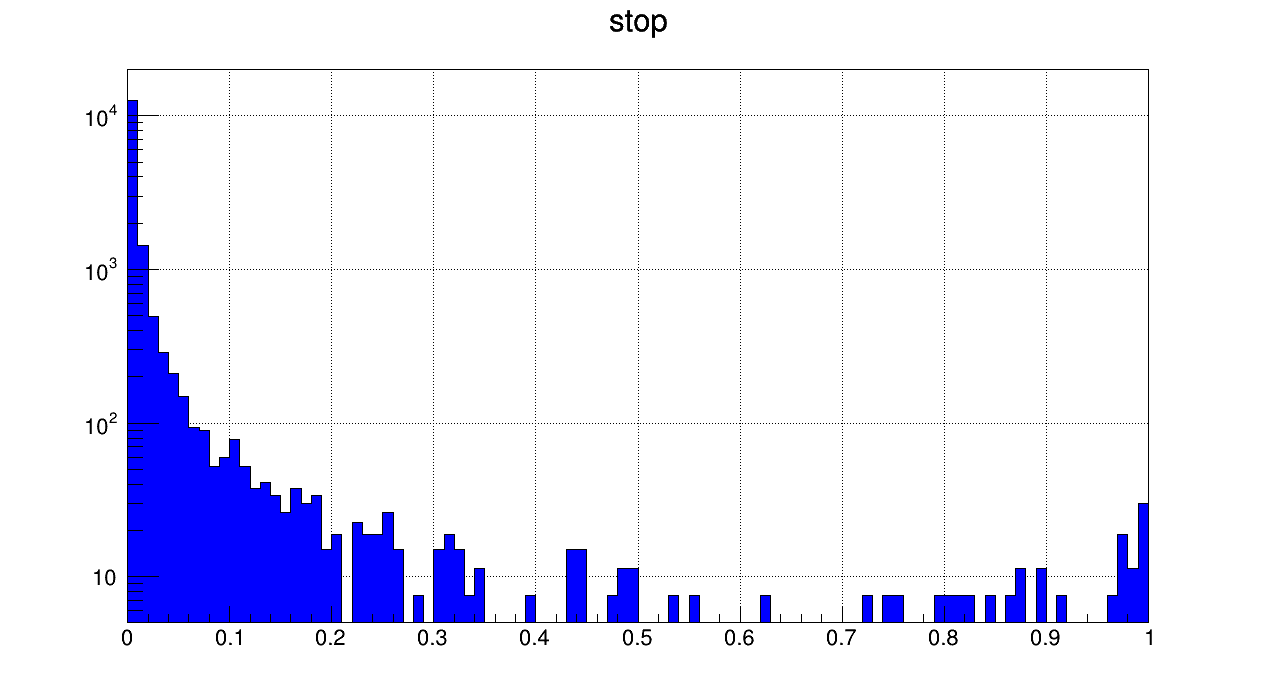

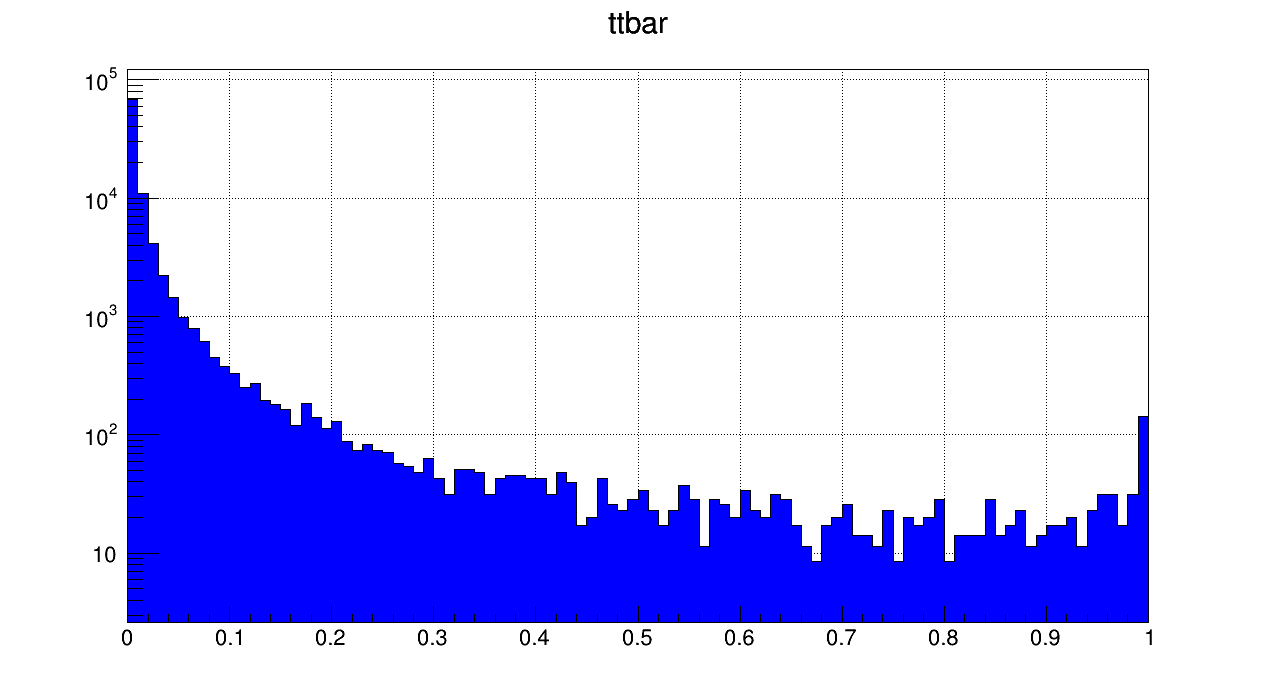

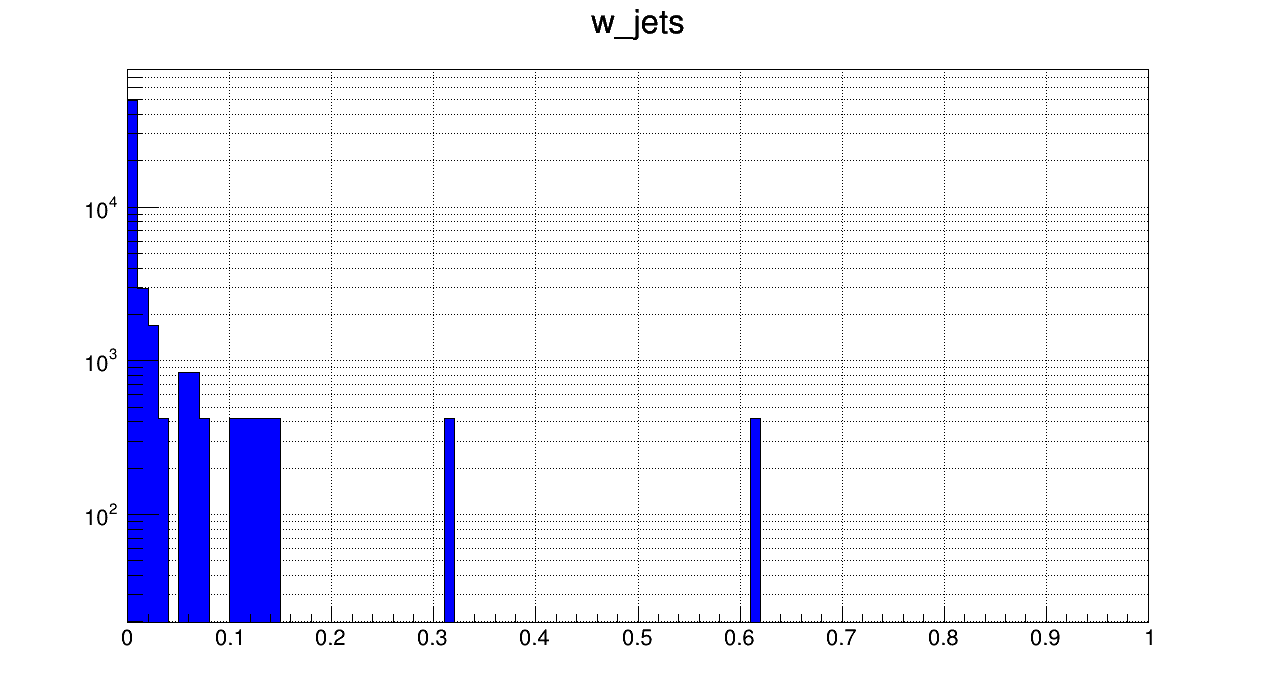

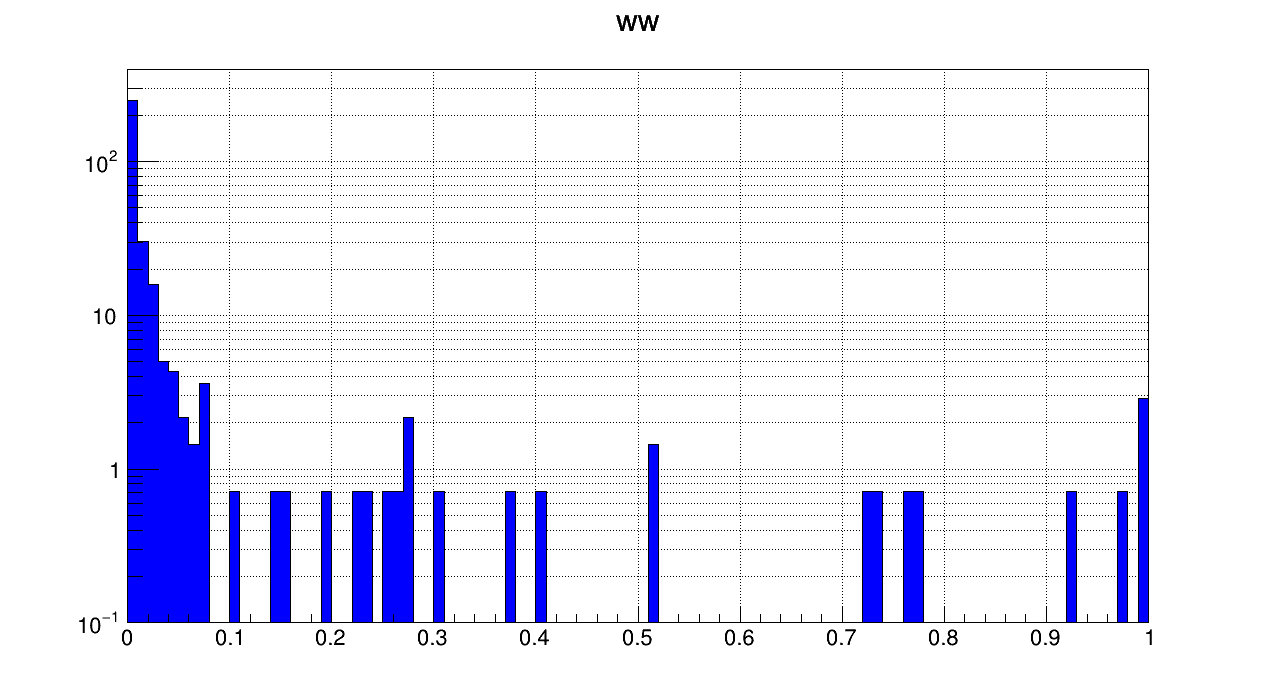

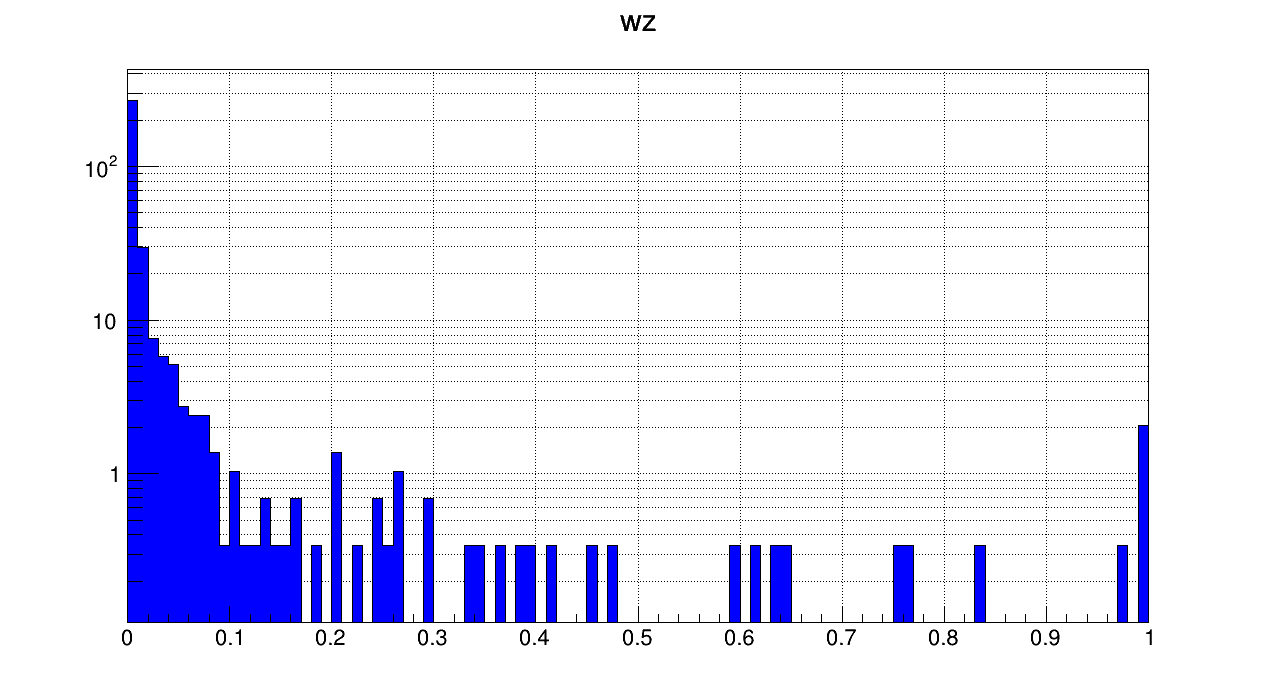

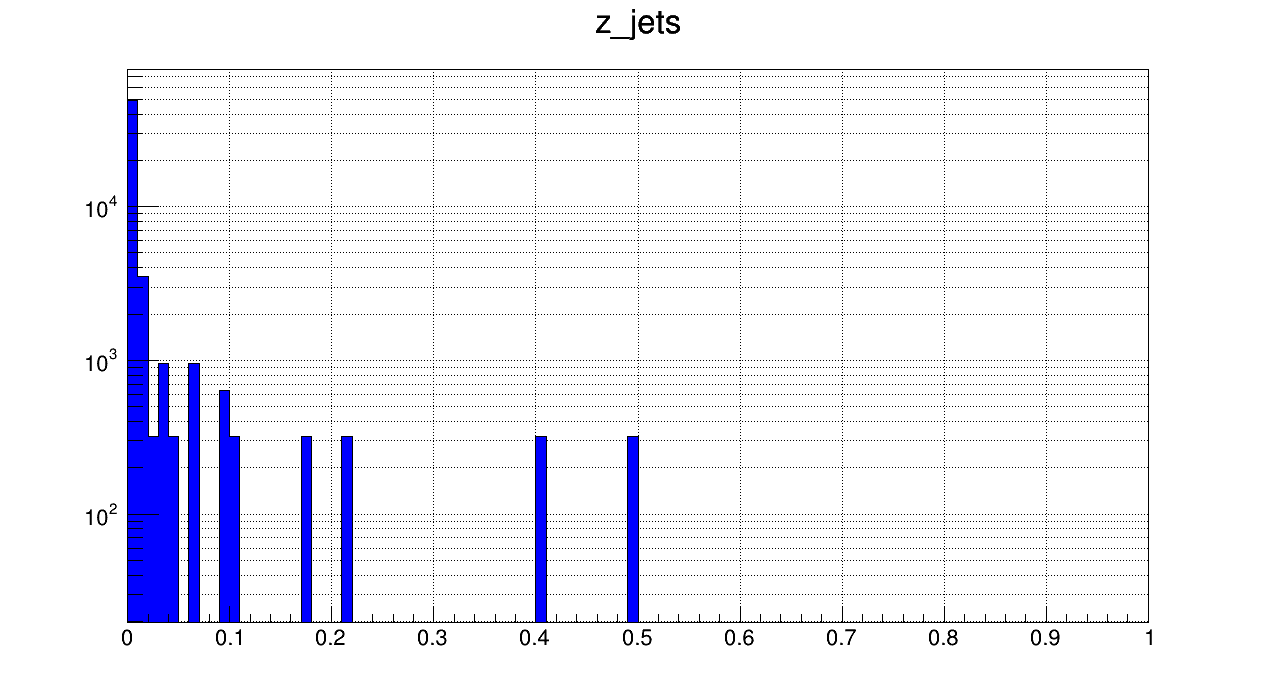

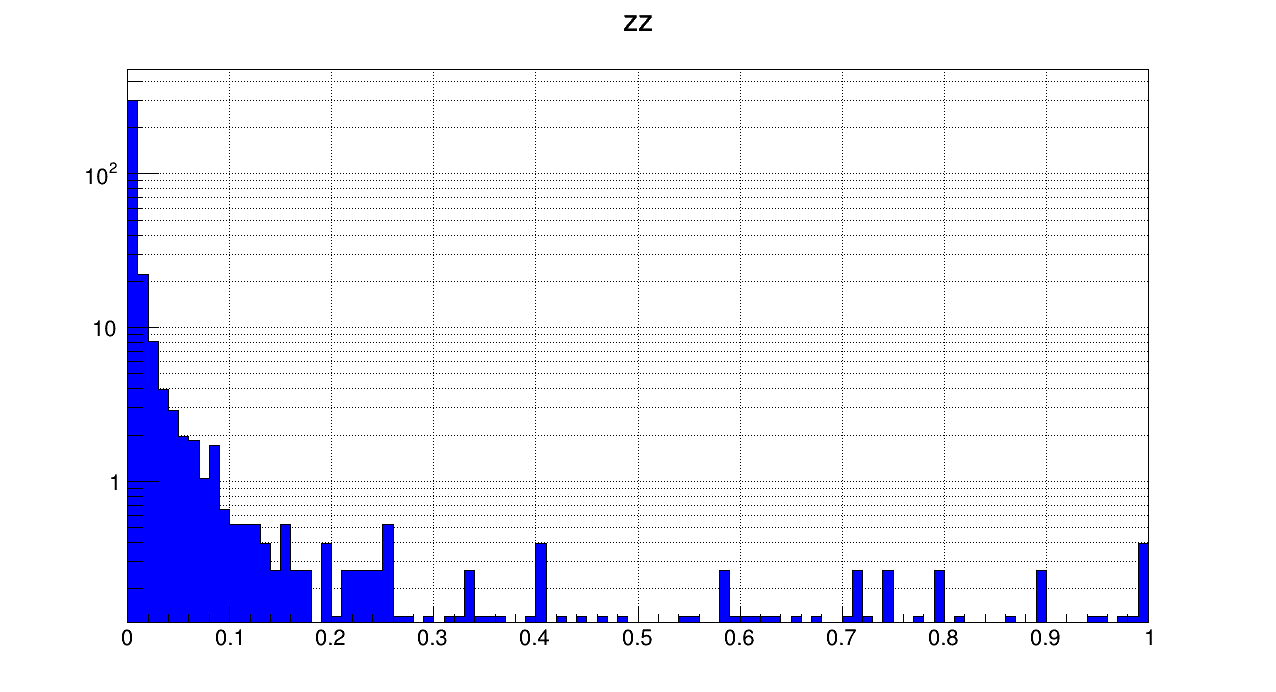

In [18]:
from IPython.display import Image, display
listOfImageNames=[]
files=next(os.walk(images_folder))[2]
for file in files:
    if ".png" in file:
        listOfImageNames+=[file]
listOfImageNames.sort()
for imageName in listOfImageNames:
    display(Image(filename=os.path.join(os.getcwd(),images_folder,imageName)))

In [19]:
histograms

{'Tau_LQ_1500': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555f939faf30>},
 'LQ_LQ_1500': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555f94916a00>},
 'ttbar': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555f94917210>},
 'stop': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555f94030780>},
 'z_jets': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555f93365ca0>},
 'w_jets': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555fbeb816b0>},
 'ww': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555fd2fa1670>},
 'wz': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555faac0c9b0>},
 'zz': {'b_tau_tau_hadronic_(al)one_jet': <cppyy.gbl.TH1F object at 0x555fc56fdda0>}}

In [20]:
threshold=0.7

In [21]:
integral=0
for channel in channels:
    h=histograms[name][channel]
    gbin1=h.FindBin(threshold)
    gbin2=h.GetMaximumBin()
    integral+=h.Integral(gbin1,gbin2)
integral

41.75098674185574

In [22]:
actual_signal_yield=0
for name in signal_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetMaximumBin()
        integral+=h.Integral(gbin1,gbin2)
    integral
    actual_signal_yield+=integral
print(signal_names,actual_signal_yield)

['Tau_LQ_1500', 'LQ_LQ_1500'] 71.89617051836103


In [23]:
actual_bkg_yield=0
for name in bkg_names:
    integral=0
    for channel in channels:
        h=histograms[name][channel]
        gbin1=h.FindBin(threshold)
        gbin2=h.GetMaximumBin()
        integral+=h.Integral(gbin1,gbin2)
    actual_bkg_yield+=integral
print(bkg_names,actual_bkg_yield)

['ttbar', 'stop', 'z_jets', 'w_jets', 'ww', 'wz', 'zz'] 891.1657166033983


In [24]:
significance=actual_signal_yield/math.sqrt(actual_signal_yield+actual_bkg_yield)
significance

2.3167472738272563

In [25]:
def get_yield_by_names(hists,names,threshold):
    signal_yield=0
    for name in names:
        integral=0
        for channel in channels:
            h=histograms[name][channel]
            gbin1=h.FindBin(threshold)
            gbin2=h.GetMaximumBin()
            integral+=h.Integral(gbin1,gbin2)
        integral
        signal_yield+=integral
    return signal_yield

In [26]:
def get_sig_by_threshold(histos,threshold=0.5):
    actual_signal_yield=get_yield_by_names(histos,signal_names,threshold)
    actual_bkg_yield=get_yield_by_names(histos,bkg_names,threshold)
    return (actual_signal_yield)/math.sqrt((actual_signal_yield)+(actual_bkg_yield)+1e-6)

In [27]:
get_sig_by_threshold(histograms,0.99)

4.315953040571484

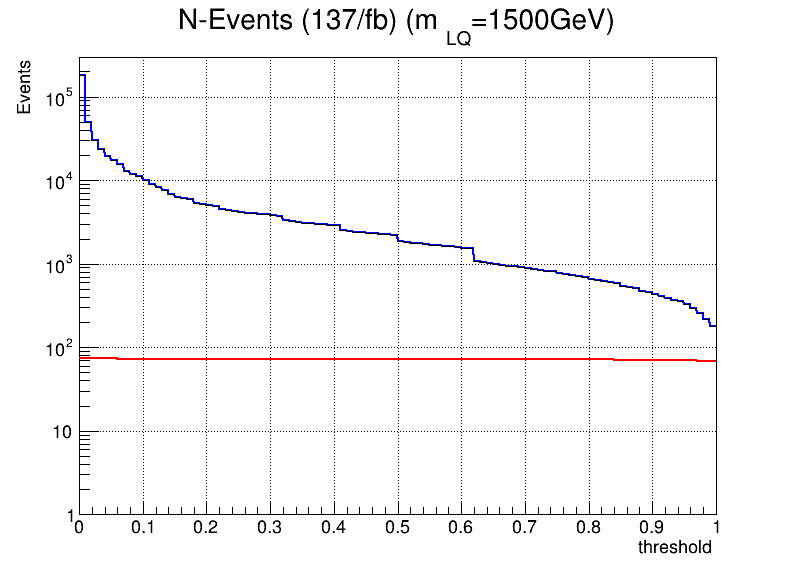

In [28]:
x=[]
y1=[]
y2=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y1+=[get_yield_by_names(histograms,bkg_names,x[i])]
    y2+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y1  = np.array(  y1 )
y2  = np.array(  y2 )

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph1=TGraph(n, x, y1)
graph1.SetTitle("N-Events (137/fb) (m_{LQ}=1500GeV);threshold; Events")
graph1.GetXaxis().SetLimits(0,1)
graph1.GetHistogram().SetMinimum(1)
graph1.GetHistogram().SetMaximum(3e5)
graph1.Draw("ALP")
graph1.SetLineColor(ROOT.kBlue)
graph1.SetLineWidth(2)

graph2=TGraph(n, x, y2)
graph2.Draw("l-same")
graph2.SetLineColor(ROOT.kRed)
graph2.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


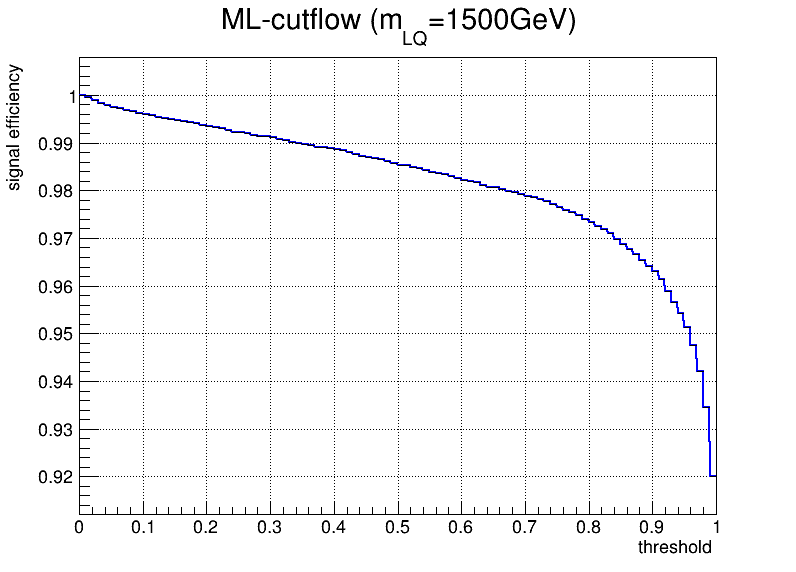

In [29]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,signal_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;signal efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


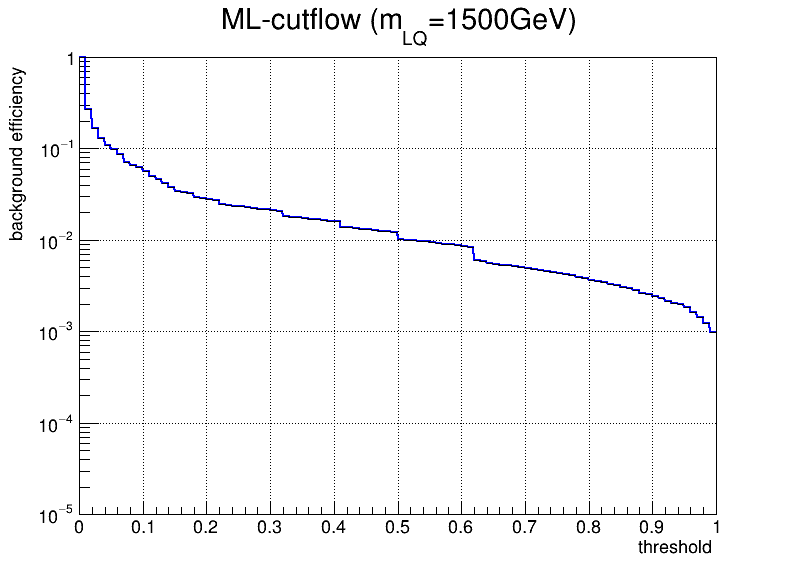

In [30]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_yield_by_names(histograms,bkg_names,x[i])]
x  = np.array(  x )
y  = np.array(  y )/y[0]

c2=TCanvas("c2","",800,600)
c2.SetLogy()
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("ML-cutflow (m_{LQ}=1500GeV);threshold;background efficiency")
graph.GetXaxis().SetLimits(0,1)
graph.GetHistogram().SetMinimum(1e-5)
graph.GetHistogram().SetMaximum(1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


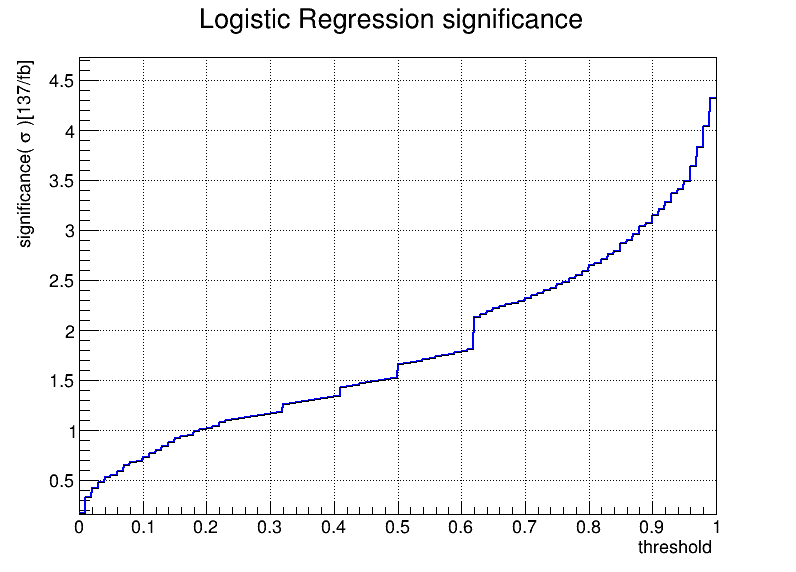

In [31]:
x=[]
y=[]
n=1000
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x )
y  = np.array(  y )
c2=TCanvas("c2","",800,600)
c2.SetGrid()
graph=TGraph(n, x, y)
graph.SetTitle("Logistic Regression significance;threshold;significance(#sigma )[137/fb]")
graph.GetXaxis().SetLimits(0,1)
graph.Draw("ALP")
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)
c2.Draw()

In [32]:
x=[]
y=[]
n=100
for i in range(n+1):
    x+=[i*(1./float(n))]
    y+=[get_sig_by_threshold(histograms,x[i])]
x  = np.array(  x  )
y  = np.array(  y  )
print(y)

[0.17287146 0.3315187  0.42218501 0.47840188 0.52355276 0.55227808
 0.58624481 0.64412397 0.67425123 0.68906273 0.72419174 0.7688266
 0.80146143 0.83892532 0.87779411 0.92098673 0.93518138 0.94734317
 0.99285053 1.00886384 1.02138048 1.03660451 1.08209176 1.09353141
 1.10599675 1.11790126 1.13099986 1.14081483 1.14908003 1.14908003
 1.16667072 1.17525055 1.25446087 1.2665529  1.27793535 1.28970988
 1.29648248 1.30588096 1.31561454 1.32614529 1.33721188 1.42852314
 1.43702308 1.45114568 1.46690498 1.47627683 1.48328521 1.49765398
 1.50790725 1.51858634 1.65395921 1.66868214 1.68071691 1.68974281
 1.70324765 1.72043739 1.73764801 1.74496201 1.74496201 1.77395182
 1.78632169 1.80715864 2.13151814 2.1564842  2.19082656 2.22015674
 2.23792323 2.2536392  2.26659362 2.28947272 2.31674727 2.34763851
 2.37011911 2.39850264 2.41863375 2.46020088 2.48289086 2.51916782
 2.55210954 2.58324874 2.64448844 2.67217389 2.71204375 2.75355099
 2.78851263 2.86536007 2.89596427 2.95438956 3.04207255 3.07031